# Key-Value Attention Mechanism Homework on Keras: Character-level Machine Translation (Many-to-Many, encoder-decoder)

In this homework, you will create an MT model with key-value attention mechnism that coverts names of constituency MP candidates in the 2019 Thai general election from Thai script to Roman(Latin) script. E.g. นิยม-->niyom 

In [1]:
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
mpl.rc('font', family='TH Sarabun New')

--2021-03-22 15:20:04--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2021-03-22 15:20:04--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘thsarabunnew-webfont.ttf’

thsarabunnew-webfon 100%[===================>]  96.00K  --.-KB/s    in 0.01s   

2021-03-22 15:20:04 (9.86 MB/s) - ‘t

In [2]:
%matplotlib inline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import numpy as np

import random

## Load Dataset
We have generated a toy dataset using names of constituency MP candidates in 2019 Thai General Election from elect.in.th's github(https://github.com/codeforthailand/dataset-election-62-candidates) and tltk (https://pypi.org/project/tltk/) library to convert them into Roman script.

<img src="https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/images/dataset_diagram.png" alt="Drawing" style="width: 500px;"/>


In [3]:
!wget https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv

--2021-03-22 15:20:06--  https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324399 (317K) [text/plain]
Saving to: ‘mp_name_th_en.csv’

mp_name_th_en.csv   100%[===================>] 316.80K  --.-KB/s    in 0.02s   

2021-03-22 15:20:06 (13.5 MB/s) - ‘mp_name_th_en.csv’ saved [324399/324399]



In [4]:
import csv
with open('mp_name_th_en.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    name_th = []
    name_en = []
    for row in readCSV:
        name_th.append(row[0])
        name_en.append(row[1])

In [5]:
for th, en in zip(name_th[:10],name_en[:10]):
    print(th,en)

ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak


## Task1: Preprocess dataset for Keras (1 point)
* 2 dictionaries for indexing (1 for input and another for output)
* DON'T FORGET TO INCLUDE special token for padding
* DON'T FORGET TO INCLUDE special token for the end of word symbol (output)
* Be mindful of your pad_sequences "padding" hyperparameter. Choose wisely (post-padding vs pre-padding)

In [29]:
#FILL YOUR CODE HERE

inputchar_th = sorted(list(set(''.join(name_th))))
inputchar_th = ["<PAD>"] + inputchar_th

outputchar_en = sorted(list(set(''.join(name_en))))
outputchar_en = ["<PAD>", "</s>"] + outputchar_en


inputchar2idx = { c:idx for idx, c in enumerate(inputchar_th)}
idx2inputchar = { idx:c for idx, c in enumerate(inputchar_th)}

outputchar2idx = { c:idx for idx, c in enumerate(outputchar_en)}
idx2outputchar = { idx:c for idx, c in enumerate(outputchar_en)}

print(input_char_th)
print(output_char_en)

['<PAD>', '<PAD>', '<PAD>', ' ', 'ก', 'ข', 'ค', 'ฆ', 'ง', 'จ', 'ฉ', 'ช', 'ซ', 'ฌ', 'ญ', 'ฎ', 'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท', 'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ล', 'ว', 'ศ', 'ษ', 'ส', 'ห', 'ฬ', 'อ', 'ฮ', 'ะ', 'ั', 'า', 'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'เ', 'แ', 'โ', 'ใ', 'ไ', '็', '่', '้', '๊', '๋', '์']
['<PAD>', '</s>', '-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'w', 'y']


In [30]:
max_input = len(max(name_th, key=len))
max_output = len(max(name_en, key=len))+1

x = [[inputchar2idx[c] for c in name] for name in name_th]
y = [[outputchar2idx[c] for c in name] for name in name_en]
x = pad_sequences(x, maxlen=max_input)
y = pad_sequences(y, maxlen=max_output)

x = to_categorical(x, len(inputchar2idx))
y = to_categorical(y, len(outputchar2idx))

print(x.shape)
print(x[:7])

print(x.shape, y.shape)

(10887, 20, 65)
[[[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 1. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 

# Attention Mechanism
## Task 2: Code your own (key-value) attention mechnism (1 point)
* PLEASE READ: you DO NOT have to follow all the details in (Daniluk, et al. 2017). You just need to create a key-value attention mechanism where the "key" part of the mechanism is used for attention score calculation, and the "value" part of the mechanism is used to encode information to create a context vector.  
* Define global variables
* fill code for one_step_attention function
* Hint: use keras.layers.Lambda 
* HINT: you will probably need more hidden dimmensions than what you've seen in the demo


In [71]:
from tensorflow.keras.activations import softmax
from tensorflow.keras.layers import Lambda
def softMaxAxis1(x):
    return softmax(x,axis=1)


In [72]:
#These are global variables (shared layers)
## Fill your code here
## you are allowed to use code in the demo as your template.
from tensorflow import split

repeator = RepeatVector(max_input)
concatenator = Concatenate(axis=-1)
splitter = Lambda(lambda tensor: split(tensor, num_or_size_splits=2, axis=-1) )

fattn_1 = Dense(10, activation = "tanh")
fattn_2 = Dense(1, activation = "relu")

activator = Activation(softMaxAxis1, name='attention_scores') 
dotor = Dot(axes = 1)

In [73]:
def one_step_attention(a, s_prev):

    #Fill code here
    a_k, a_v = splitter(a)
    s_prev = repeator(s_prev)
    concat = concatenator([a_k, s_prev])

    e = fattn_1(concat)
    en = fattn_2(e)

    attention_scores = activator(en)
    r = concatenator([a_v, s_prev])
    re = fattn_1(r)

    context =  dotor([attention_scores, re])
    return context # return whatever you need to complete this homework 

## Task3: Create and train your encoder/decoder model here (1 point)
* HINT: you will probably need more hidden dimmensions than what you've seen in the demo

In [74]:
#FILL CODE HERE
n_h = 64 #hidden dimensions for encoder 
n_s = 64 #hidden dimensions for decoder
m = 10887
encoder_LSTM =  Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(-1, max_input, n_h*2))
decoder_LSTM_cell = LSTM(n_s, return_state = True) #decoder_LSTM_cell
output_layer = Dense(output_vocab_size, activation="softmax") #softmax output layer

s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(y.swapaxes(0,1))

In [75]:
tf.keras.backend.clear_session()

def model(Tx, Ty, n_h, n_s, input_vocab_size, output_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_h -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    input_vocab_size -- size of the input vocab
    output_vocab_size -- size of the output vocab

    Returns:
    model -- Keras model instance
    """
    
    # Define the input of your model
    X = Input(shape=(Tx, len(inputchar2idx)))
    # Define hidden state and cell state for decoder_LSTM_Cell
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = list()
    #Encoder Bi-LSTM
    # h = Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(-1, Tx, n_h*2))(X)
    h = encoder_LSTM(X)
    #Iterate for Ty steps (Decoding)
    for t in range(Ty):
    
        #Perform one step of the attention mechanism to calculate the context vector at timestep t
        context = one_step_attention(h, s)
       
        # Feed the context vector to the decoder LSTM cell
        s, _, c = decoder_LSTM_cell(context,initial_state=[s,c])
           
        # Pass the decoder hidden output to the output layer (softmax)
        out = output_layer(s)
        
        # Append an output list with the current output
        outputs.append(out)
    
    #Create model instance
    model = Model(inputs=[X,s0,c0],outputs=outputs)
    model.summary()
    return model

model = model(max_input, max_output, n_h, n_s, len(inputchar2idx), len(outputchar2idx))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 65)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 20, 128)      66560       input_1[0][0]                    
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 [(None, 20, 64), (No 0           bidirectional[0][0]              
                                                                 bidirectional[0][0]          

In [76]:
#FIT YOUR MODEL HERE
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr= 0.01, clipvalue=0.5),metrics=['accuracy'])
model.fit([x, s0, c0], outputs, epochs=35, batch_size=64)

Epoch 1/35
171/171 [==============================] - 60s 109ms/step - loss: 30.9055 - dense_2_loss: 0.6845 - dense_2_1_loss: 0.4579 - dense_2_2_loss: 0.3964 - dense_2_3_loss: 0.3774 - dense_2_4_loss: 0.3793 - dense_2_5_loss: 0.3941 - dense_2_6_loss: 0.4324 - dense_2_7_loss: 0.5015 - dense_2_8_loss: 0.6100 - dense_2_9_loss: 0.7774 - dense_2_10_loss: 1.0709 - dense_2_11_loss: 1.4603 - dense_2_12_loss: 1.9663 - dense_2_13_loss: 2.5730 - dense_2_14_loss: 2.9883 - dense_2_15_loss: 3.2146 - dense_2_16_loss: 3.2045 - dense_2_17_loss: 3.3885 - dense_2_18_loss: 3.0505 - dense_2_19_loss: 2.9777 - dense_2_accuracy: 0.9943 - dense_2_1_accuracy: 0.9941 - dense_2_2_accuracy: 0.9935 - dense_2_3_accuracy: 0.9922 - dense_2_4_accuracy: 0.9893 - dense_2_5_accuracy: 0.9850 - dense_2_6_accuracy: 0.9776 - dense_2_7_accuracy: 0.9651 - dense_2_8_accuracy: 0.9430 - dense_2_9_accuracy: 0.9085 - dense_2_10_accuracy: 0.8315 - dense_2_11_accuracy: 0.7204 - dense_2_12_accuracy: 0.5615 - dense_2_13_accuracy: 0.3561

# Thai-Script to Roman-Script Translation
* Task 4: Test your model on 5 examples of your choice including your name! (1 point)
* Task 5: Show your visualization of attention scores on one of your example (1 point)

In [64]:
#task 4
#fill your code here
def prep_input(input_list):
    prep = []
    for line in input_list:
        temp = []
        for char in line:
            temp.append(inputchar2idx[char])
        prep.append(temp)
    prep = pad_sequences(prep, maxlen=max_input)
    prep = to_categorical(prep, len(inputchar2idx))
    return prep

EXAMPLES = ["กรวิช", "สุชัญญา", "กริส", "คริส", "คริษฐ์"]

s0 = np.zeros((len(EXAMPLES), n_s))
c0 = np.zeros((len(EXAMPLES), n_s))
prep = prep_input(EXAMPLES)

pred_a = model.predict([prep, s0, c0])
pred_b = np.swapaxes(pred_a, 0, 1)
pred = np.argmax(pred_b, axis=-1)
for j in range(len(pred)):
    output = ("".join([idx2outputchar[int(i)] for i in pred[j]])).strip("<PAD>")
    print('in nameth:', EXAMPLES[j] in name_th, EXAMPLES[j], '=>', output)


in nameth: False กรวิช => konwit
in nameth: False สุชัญญา => suchanya
in nameth: False กริส => krrit
in nameth: True คริส => khrrit
in nameth: False คริษฐ์ => hrrit


### Plot the attention map
* If you need to install thai font: sudo apt install xfonts-thai
* this is what your visualization might look like:
<img src="https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/images/attn_viz_sample.png"  style="width: 350px;"/>

In [84]:
#task 5
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family']='TH Sarabun New'  #you can change to other font that works for you
#fill your code here
model_att = Model(inputs=model.inputs, outputs=[model.outputs, [model.get_layer('attention_scores').get_output_at(e) for e in range(max_output)]])

In [93]:
EXAMPLES_NAME = "คริษฐ์"
EXAMPLES_NAME_pad = ["<PAD>" for i in range(max_input-len(EXAMPLES_NAME))] + list(EXAMPLES_NAME)

prep_name = prep_input([EXAMPLES_NAME])
s0 = np.zeros((len(prep_name), n_s))
c0 = np.zeros((len(prep_name), n_s))

pred_name = model_att.predict([prep_name, s0, c0])

pred_name_out = np.swapaxes(pred_name[0], 0, 1)
pred_name_out = np.argmax(pred_name_out, axis=-1)

output = [idx2outputchar[int(i)] for i in pred_name_out[0]]
print("".join(EXAMPLES_NAME_pad))
print(''.join(output))

<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>คริษฐ์
<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>khirit


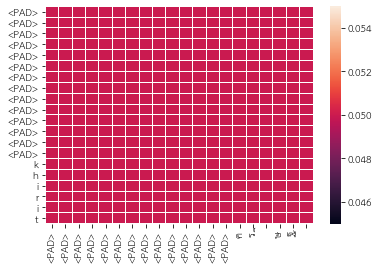

In [94]:
att_score = np.array(pred_name[1]).reshape(20,20)

sns.heatmap(att_score, xticklabels=EXAMPLES_NAME_pad, yticklabels=output ,linewidths=0.01)
plt.show()

In [95]:
"why 55555"

'why 55555'